# Tugas Data Multimedia TBD
Nama : Husni Na'fa Mubarok
<br>NIM  : 121450078
<br>Kelas: TBD RA

## Setup

### Import Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pickle
from pathlib import Path

# Path to the unzipped CIFAR data
data_dir = Path("/content/drive/MyDrive/Kuliah/Semester 6/Teknologi Basis Data/data/cifar-10-batches-py/")

# Unpickle function provided by the CIFAR hosts
def unpickle(file):
    with open(file, "rb") as fo:
        dict = pickle.load(fo, encoding="bytes")
    return dict

images, labels = [], []
for batch in data_dir.glob("data_batch_*"):
    batch_data = unpickle(batch)
    for i, flat_im in enumerate(batch_data[b"data"]):
        im_channels = []
        # Each image is flattened, with channels in order of R, G, B
        for j in range(3):
            im_channels.append(
                flat_im[j * 1024 : (j + 1) * 1024].reshape((32, 32))
            )
        # Reconstruct the original image
        images.append(np.dstack((im_channels)))
        # Save the label
        labels.append(batch_data[b"labels"][i])

print("Loaded CIFAR-10 training set:")
print(f" - np.shape(images)     {np.shape(images)}")
print(f" - np.shape(labels)     {np.shape(labels)}")

Loaded CIFAR-10 training set:
 - np.shape(images)     (50000, 32, 32, 3)
 - np.shape(labels)     (50000,)


### Install Package yang diperlukan

In [3]:
!pip install Pillow

In [4]:
!pip install lmdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 3.9 MB/s eta 0:00:00


In [5]:
!pip install h5py

### Buat folder untuk setiap metode

In [6]:
from pathlib import Path

disk_dir = Path("/content/drive/MyDrive/Kuliah/Semester 6/Teknologi Basis Data/data/disk/")
lmdb_dir = Path("/content/drive/MyDrive/Kuliah/Semester 6/Teknologi Basis Data/data/lmdb/")
hdf5_dir = Path("/content/drive/MyDrive/Kuliah/Semester 6/Teknologi Basis Data/data/hdf5/")

In [7]:
disk_dir.mkdir(parents=True, exist_ok=True)
lmdb_dir.mkdir(parents=True, exist_ok=True)
hdf5_dir.mkdir(parents=True, exist_ok=True)

### Buat fungsi untuk menyimpan gambar tunggal dengan metode disk/PNG

In [8]:
from PIL import Image
import csv

def store_single_disk(image, image_id, label):
    """ Stores a single image as a .png file on disk.
        Parameters:
        ---------------
        image       image array, (32, 32, 3) to be stored
        image_id    integer unique ID for image
        label       image label
    """
    Image.fromarray(image).save(disk_dir / f"{image_id}.png")

    with open(disk_dir / f"{image_id}.csv", "wt") as csvfile:
        writer = csv.writer(
            csvfile, delimiter=" ", quotechar="|", quoting=csv.QUOTE_MINIMAL
        )
        writer.writerow([label])

In [9]:
class CIFAR_Image:
    def __init__(self, image, label):
        # Dimensions of image for reconstruction - not really necessary
        # for this dataset, but some datasets may include images of
        # varying sizes
        self.channels = image.shape[2]
        self.size = image.shape[:2]

        self.image = image.tobytes()
        self.label = label

    def get_image(self):
        """ Returns the image as a numpy array. """
        image = np.frombuffer(self.image, dtype=np.uint8)
        return image.reshape(*self.size, self.channels)

### Buat fungsi untuk menyimpan gambar tunggal dengan metode LMDB

In [10]:
import lmdb
import pickle

def store_single_lmdb(image, image_id, label):
    """ Stores a single image to a LMDB.
        Parameters:
        ---------------
        image       image array, (32, 32, 3) to be stored
        image_id    integer unique ID for image
        label       image label
    """
    map_size = image.nbytes * 10

    # Create a new LMDB environment
    env = lmdb.open(str(lmdb_dir / f"single_lmdb"), map_size=map_size)

    # Start a new write transaction
    with env.begin(write=True) as txn:
        # All key-value pairs need to be strings
        value = CIFAR_Image(image, label)
        key = f"{image_id:08}"
        txn.put(key.encode("ascii"), pickle.dumps(value))
    env.close()

### Buat fungsi untuk menyimpan gambar tunggal dengan metode HDF5

In [11]:
import h5py

def store_single_hdf5(image, image_id, label):
    """ Stores a single image to an HDF5 file.
        Parameters:
        ---------------
        image       image array, (32, 32, 3) to be stored
        image_id    integer unique ID for image
        label       image label
    """
    # Create a new HDF5 file
    file = h5py.File(hdf5_dir / f"{image_id}.h5", "w")

    # Create a dataset in the file
    dataset = file.create_dataset(
        "image", np.shape(image), h5py.h5t.STD_U8BE, data=image
    )
    meta_set = file.create_dataset(
        "meta", np.shape(label), h5py.h5t.STD_U8BE, data=label
    )
    file.close()

In [12]:
_store_single_funcs = dict(
    disk=store_single_disk, lmdb=store_single_lmdb, hdf5=store_single_hdf5
)

### Running ketiga metode dengan menghitung Waktu Proses

In [13]:
from timeit import timeit

store_single_timings = dict()

for method in ("disk", "lmdb", "hdf5"):
    t = timeit(
        "_store_single_funcs[method](image, 0, label)",
        setup="image=images[0]; label=labels[0]",
        number=1,
        globals=globals(),
    )
    store_single_timings[method] = t
    print(f"Method: {method}, Time usage: {t}")

Method: disk, Time usage: 0.03682135500002914
Method: lmdb, Time usage: 0.036205622000125004
Method: hdf5, Time usage: 0.016456544999982725


HDF5 paling efektif dalam menyimpan data Gambar Tunggal

### Buat fungsi untuk menyimpan gambar jamak dengan metode disk/PNG, LMDB, HDF5

In [14]:
def store_many_disk(images, labels):
    """ Stores an array of images to disk
        Parameters:
        ---------------
        images       images array, (N, 32, 32, 3) to be stored
        labels       labels array, (N, 1) to be stored
    """
    num_images = len(images)

    # Save all the images one by one
    for i, image in enumerate(images):
        Image.fromarray(image).save(disk_dir / f"{i}.png")

    # Save all the labels to the csv file
    with open(disk_dir / f"{num_images}.csv", "w") as csvfile:
        writer = csv.writer(
            csvfile, delimiter=" ", quotechar="|", quoting=csv.QUOTE_MINIMAL
        )
        for label in labels:
            # This typically would be more than just one value per row
            writer.writerow([label])

def store_many_lmdb(images, labels):
    """ Stores an array of images to LMDB.
        Parameters:
        ---------------
        images       images array, (N, 32, 32, 3) to be stored
        labels       labels array, (N, 1) to be stored
    """
    num_images = len(images)

    map_size = num_images * images[0].nbytes * 10

    # Create a new LMDB DB for all the images
    env = lmdb.open(str(lmdb_dir / f"{num_images}_lmdb"), map_size=map_size)

    # Same as before — but let's write all the images in a single transaction
    with env.begin(write=True) as txn:
        for i in range(num_images):
            # All key-value pairs need to be Strings
            value = CIFAR_Image(images[i], labels[i])
            key = f"{i:08}"
            txn.put(key.encode("ascii"), pickle.dumps(value))
    env.close()

def store_many_hdf5(images, labels):
    """ Stores an array of images to HDF5.
        Parameters:
        ---------------
        images       images array, (N, 32, 32, 3) to be stored
        labels       labels array, (N, 1) to be stored
    """
    num_images = len(images)

    # Create a new HDF5 file
    file = h5py.File(hdf5_dir / f"{num_images}_many.h5", "w")

    # Create a dataset in the file
    dataset = file.create_dataset(
        "images", np.shape(images), h5py.h5t.STD_U8BE, data=images
    )
    meta_set = file.create_dataset(
        "meta", np.shape(labels), h5py.h5t.STD_U8BE, data=labels
    )
    file.close()

In [15]:
cutoffs = [10, 100, 1000, 10000, 100000]

# Let's double our images so that we have 100,000
images = np.concatenate((images, images), axis=0)
labels = np.concatenate((labels, labels), axis=0)

# Make sure you actually have 100,000 images and labels
print(np.shape(images))
print(np.shape(labels))

(100000, 32, 32, 3)
(100000,)


### Running ketiga metode dengan menghitung Waktu Proses

In [16]:
_store_many_funcs = dict(
    disk=store_many_disk, lmdb=store_many_lmdb, hdf5=store_many_hdf5
)

from timeit import timeit

store_many_timings = {"disk": [], "lmdb": [], "hdf5": []}

for cutoff in cutoffs:
    for method in ("disk", "lmdb", "hdf5"):
        t = timeit(
            "_store_many_funcs[method](images_, labels_)",
            setup="images_=images[:cutoff]; labels_=labels[:cutoff]",
            number=1,
            globals=globals(),
        )
        store_many_timings[method].append(t)

        # Print out the method, cutoff, and elapsed time
        print(f"Method: {method}, Time usage: {t}")

Method: disk, Time usage: 0.1449962859999232
Method: lmdb, Time usage: 0.026440567999998166
Method: hdf5, Time usage: 0.01110842999992201
Method: disk, Time usage: 0.9677009649999491
Method: lmdb, Time usage: 0.03079636200004643
Method: hdf5, Time usage: 0.011870815000065704
Method: disk, Time usage: 9.698931681999966
Method: lmdb, Time usage: 0.07005985199998577
Method: hdf5, Time usage: 0.023251088000051823
Method: disk, Time usage: 100.32343318500011
Method: lmdb, Time usage: 0.39455052500011334
Method: hdf5, Time usage: 0.14272458799996457
Method: disk, Time usage: 1038.744751183
Method: lmdb, Time usage: 5.958539410999947
Method: hdf5, Time usage: 3.9415433839999423


HDF5 paling efektif menyimpan gambar dalam jumlah banyak

### Membuat visualisasi perbandingan Menyimpan gambar dari ketiga metode berdasarjan Jumlah Gambar dan Waktu Proses penyimpanan dan nilai logaritmiknya

<ipython-input-17-99d89538a067>:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


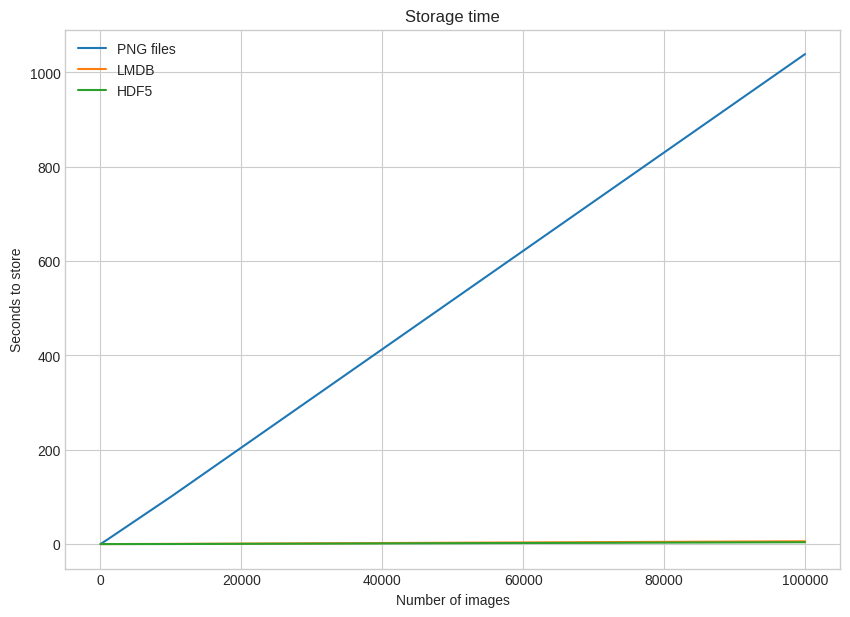

<ipython-input-17-99d89538a067>:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


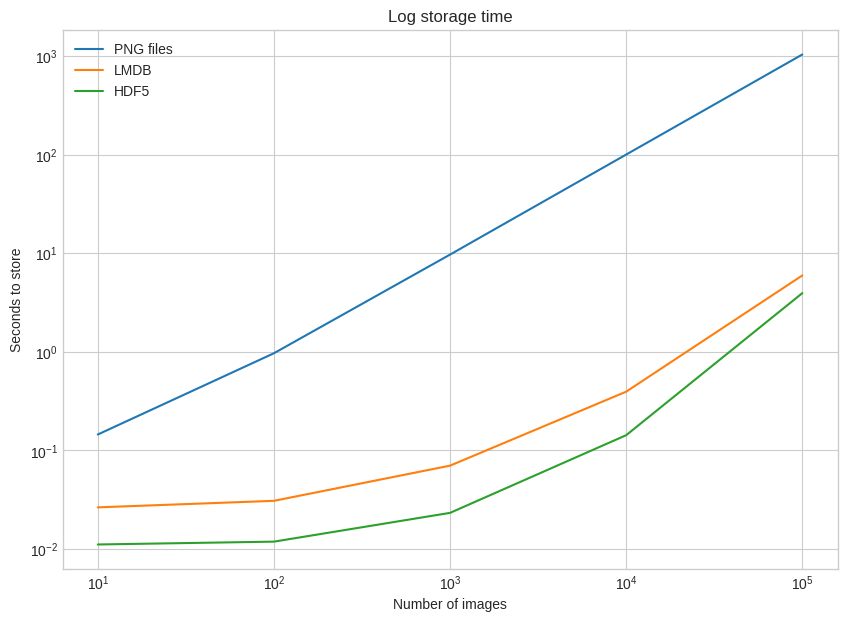

In [17]:
import matplotlib.pyplot as plt

def plot_with_legend(
    x_range, y_data, legend_labels, x_label, y_label, title, log=False
):
    """ Displays a single plot with multiple datasets and matching legends.
        Parameters:
        --------------
        x_range         list of lists containing x data
        y_data          list of lists containing y values
        legend_labels   list of string legend labels
        x_label         x axis label
        y_label         y axis label
    """
    plt.style.use("seaborn-whitegrid")
    plt.figure(figsize=(10, 7))

    if len(y_data) != len(legend_labels):
        raise TypeError(
            "Error: number of data sets does not match number of labels."
        )

    all_plots = []
    for data, label in zip(y_data, legend_labels):
        if log:
            temp, = plt.loglog(x_range, data, label=label)
        else:
            temp, = plt.plot(x_range, data, label=label)
        all_plots.append(temp)

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(handles=all_plots)
    plt.show()

# Getting the store timings data to display
disk_x = store_many_timings["disk"]
lmdb_x = store_many_timings["lmdb"]
hdf5_x = store_many_timings["hdf5"]

plot_with_legend(
    cutoffs,
    [disk_x, lmdb_x, hdf5_x],
    ["PNG files", "LMDB", "HDF5"],
    "Number of images",
    "Seconds to store",
    "Storage time",
    log=False,
)

plot_with_legend(
    cutoffs,
    [disk_x, lmdb_x, hdf5_x],
    ["PNG files", "LMDB", "HDF5"],
    "Number of images",
    "Seconds to store",
    "Log storage time",
    log=True,
)

Dari plot diatas menunjukan bahwa HDF5 paling efektif menyimpan gambar dalam jumlah banyak

### Buat fungsi untuk membaca gambar tunggal dengan metode disk/PNG

In [18]:
def read_single_disk(image_id):
    """ Stores a single image to disk.
        Parameters:
        ---------------
        image_id    integer unique ID for image

        Returns:
        ----------
        image       image array, (32, 32, 3) to be stored
        label       associated meta data, int label
    """
    image = np.array(Image.open(disk_dir / f"{image_id}.png"))

    with open(disk_dir / f"{image_id}.csv", "r") as csvfile:
        reader = csv.reader(
            csvfile, delimiter=" ", quotechar="|", quoting=csv.QUOTE_MINIMAL
        )
        label = int(next(reader)[0])

    return image, label

### Buat fungsi untuk membaca gambar tunggal dengan metode LMDB

In [19]:
def read_single_lmdb(image_id):
    """ Stores a single image to LMDB.
        Parameters:
        ---------------
        image_id    integer unique ID for image

        Returns:
        ----------
        image       image array, (32, 32, 3) to be stored
        label       associated meta data, int label
    """
    # Open the LMDB environment
    env = lmdb.open(str(lmdb_dir / f"single_lmdb"), readonly=True)

    # Start a new read transaction
    with env.begin() as txn:
        # Encode the key the same way as we stored it
        data = txn.get(f"{image_id:08}".encode("ascii"))
        # Remember it's a CIFAR_Image object that is loaded
        cifar_image = pickle.loads(data)
        # Retrieve the relevant bits
        image = cifar_image.get_image()
        label = cifar_image.label
    env.close()

    return image, label

### Buat fungsi untuk membaca gambar tunggal dengan metode HDF5

In [20]:
def read_single_hdf5(image_id):
    """ Stores a single image to HDF5.
        Parameters:
        ---------------
        image_id    integer unique ID for image

        Returns:
        ----------
        image       image array, (32, 32, 3) to be stored
        label       associated meta data, int label
    """
    # Open the HDF5 file
    file = h5py.File(hdf5_dir / f"{image_id}.h5", "r+")

    image = np.array(file["/image"]).astype("uint8")
    label = int(np.array(file["/meta"]).astype("uint8"))

    return image, label

In [21]:
_read_single_funcs = dict(
    disk=read_single_disk, lmdb=read_single_lmdb, hdf5=read_single_hdf5
)

### Running ketiga metode dengan menghitung Waktu Proses

In [22]:
from timeit import timeit

read_single_timings = dict()

for method in ("disk", "lmdb", "hdf5"):
    t = timeit(
        "_read_single_funcs[method](0)",
        setup="image=images[0]; label=labels[0]",
        number=1,
        globals=globals(),
    )
    read_single_timings[method] = t
    print(f"Method: {method}, Time usage: {t}")

Method: disk, Time usage: 0.01615181199986182
Method: lmdb, Time usage: 0.38318380299961063
Method: hdf5, Time usage: 0.3291782369997236


disk/PNG paling efektif dalam membaca gambar tunggal

### Buat fungsi untuk membaca gambar jamak dengan metode disk/PNG, LMDB, HDF5

In [23]:
def read_many_disk(num_images):
    """ Reads image from disk.
        Parameters:
        ---------------
        num_images   number of images to read

        Returns:
        ----------
        images      images array, (N, 32, 32, 3) to be stored
        labels      associated meta data, int label (N, 1)
    """
    images, labels = [], []

    # Loop over all IDs and read each image in one by one
    for image_id in range(num_images):
        images.append(np.array(Image.open(disk_dir / f"{image_id}.png")))

    with open(disk_dir / f"{num_images}.csv", "r") as csvfile:
        reader = csv.reader(
            csvfile, delimiter=" ", quotechar="|", quoting=csv.QUOTE_MINIMAL
        )
        for row in reader:
            labels.append(int(row[0]))
    return images, labels

def read_many_lmdb(num_images):
    """ Reads image from LMDB.
        Parameters:
        ---------------
        num_images   number of images to read

        Returns:
        ----------
        images      images array, (N, 32, 32, 3) to be stored
        labels      associated meta data, int label (N, 1)
    """
    images, labels = [], []
    env = lmdb.open(str(lmdb_dir / f"{num_images}_lmdb"), readonly=True)

    # Start a new read transaction
    with env.begin() as txn:
        # Read all images in one single transaction, with one lock
        # We could split this up into multiple transactions if needed
        for image_id in range(num_images):
            data = txn.get(f"{image_id:08}".encode("ascii"))
            # Remember that it's a CIFAR_Image object
            # that is stored as the value
            cifar_image = pickle.loads(data)
            # Retrieve the relevant bits
            images.append(cifar_image.get_image())
            labels.append(cifar_image.label)
    env.close()
    return images, labels

def read_many_hdf5(num_images):
    """ Reads image from HDF5.
        Parameters:
        ---------------
        num_images   number of images to read

        Returns:
        ----------
        images      images array, (N, 32, 32, 3) to be stored
        labels      associated meta data, int label (N, 1)
    """
    images, labels = [], []

    # Open the HDF5 file
    file = h5py.File(hdf5_dir / f"{num_images}_many.h5", "r+")

    images = np.array(file["/images"]).astype("uint8")
    labels = np.array(file["/meta"]).astype("uint8")

    return images, labels

_read_many_funcs = dict(
    disk=read_many_disk, lmdb=read_many_lmdb, hdf5=read_many_hdf5
)

### Running ketiga metode dengan menghitung Waktu Proses

In [24]:
from timeit import timeit

read_many_timings = {"disk": [], "lmdb": [], "hdf5": []}

for cutoff in cutoffs:
    for method in ("disk", "lmdb", "hdf5"):
        t = timeit(
            "_read_many_funcs[method](num_images)",
            setup="num_images=cutoff",
            number=1,
            globals=globals(),
        )
        read_many_timings[method].append(t)

        # Print out the method, cutoff, and elapsed time
        print(f"Method: {method}, No. images: {cutoff}, Time usage: {t}")

Method: disk, No. images: 10, Time usage: 0.09796188300015274
Method: lmdb, No. images: 10, Time usage: 0.35383332599985806
Method: hdf5, No. images: 10, Time usage: 0.3224782479996975
Method: disk, No. images: 100, Time usage: 0.5609511470001962
Method: lmdb, No. images: 100, Time usage: 0.30965971100022216
Method: hdf5, No. images: 100, Time usage: 0.3876292819995797
Method: disk, No. images: 1000, Time usage: 5.749361143999977
Method: lmdb, No. images: 1000, Time usage: 0.3556238989999656
Method: hdf5, No. images: 1000, Time usage: 0.37469239799975185
Method: disk, No. images: 10000, Time usage: 55.1116159029998
Method: lmdb, No. images: 10000, Time usage: 0.8717021770003157
Method: hdf5, No. images: 10000, Time usage: 0.49022635499977696
Method: disk, No. images: 100000, Time usage: 575.5995162980003
Method: lmdb, No. images: 100000, Time usage: 1.9500906850003048
Method: hdf5, No. images: 100000, Time usage: 1.3534562479999295


HDF5 paling efektif membaca gambar dalam jumlah banyak

### Membuat visualisasi perbandingan membaca gambar dari ketiga metode berdasarkan Jumlah Gambar dan Waktu Proses membaca dan nilai logaritmiknya

<ipython-input-17-99d89538a067>:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


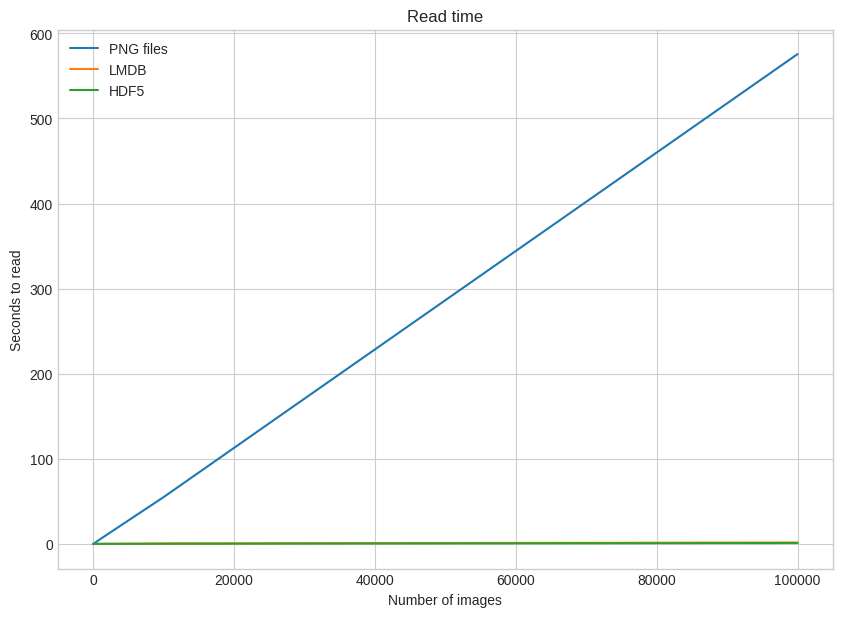

<ipython-input-17-99d89538a067>:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


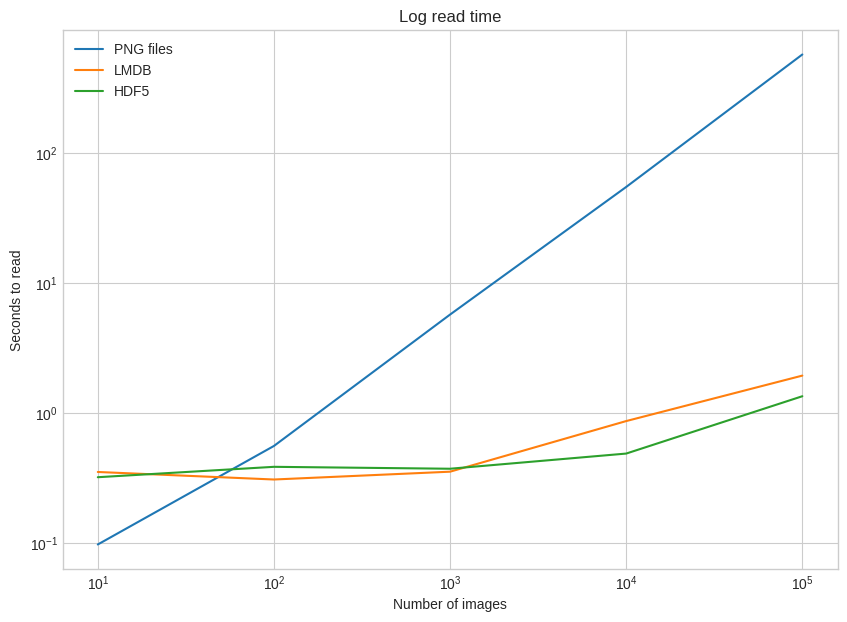

In [25]:
disk_x_r = read_many_timings["disk"]
lmdb_x_r = read_many_timings["lmdb"]
hdf5_x_r = read_many_timings["hdf5"]

plot_with_legend(
    cutoffs,
    [disk_x_r, lmdb_x_r, hdf5_x_r],
    ["PNG files", "LMDB", "HDF5"],
    "Number of images",
    "Seconds to read",
    "Read time",
    log=False,
)

plot_with_legend(
    cutoffs,
    [disk_x_r, lmdb_x_r, hdf5_x_r],
    ["PNG files", "LMDB", "HDF5"],
    "Number of images",
    "Seconds to read",
    "Log read time",
    log=True,
)

Dari plot diatas menunjukan bahwa pada gambar tunggal disk lebih efektif untuk membaca gambar, sedangkan pada gambar banyak HDF5 lebih efektif dalam membaca gambar

### Membuat visualisasi perbandingan Menyimpan dan Membaca gambar dari ketiga metode berdasarkan Jumlah Gambar dan Waktu Proses penyimpanan/membaca

<ipython-input-17-99d89538a067>:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


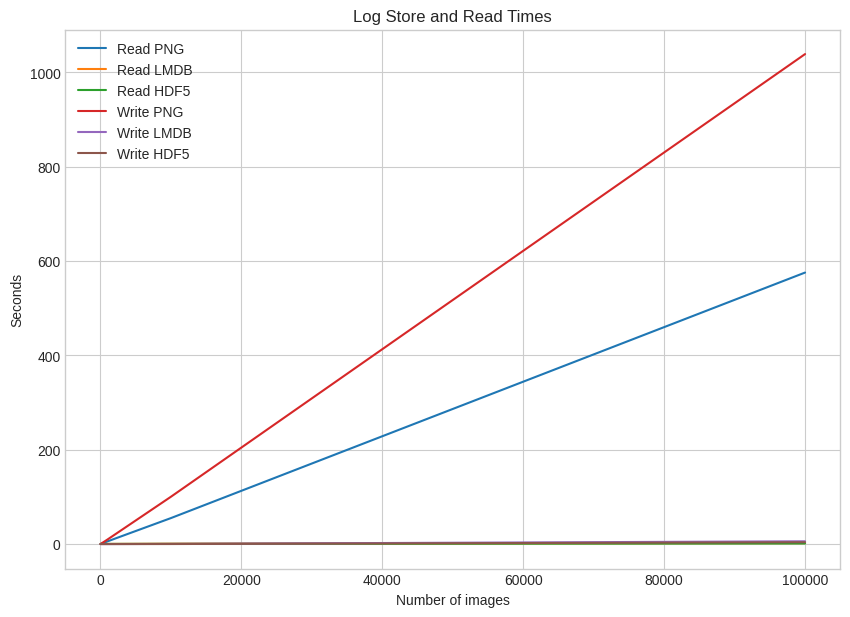

In [26]:
plot_with_legend(
    cutoffs,
    [disk_x_r, lmdb_x_r, hdf5_x_r, disk_x, lmdb_x, hdf5_x],
    [
        "Read PNG",
        "Read LMDB",
        "Read HDF5",
        "Write PNG",
        "Write LMDB",
        "Write HDF5",
    ],
    "Number of images",
    "Seconds",
    "Store and Read Times",
    log=False,
)

Dari plot berikut dapat diketahui bahwa disk(PNG) membentuk pola linear dalam proses menyimpan dan membaca data (Big O Notation : O(n)). Sedangkan LMDB dan HDF5 membentuk pola logaritmik dalam proses menyimpan dan membaca data (Big O Notation : O(log n)).

### Visualisasi penggunaan memori/penyimpanan dari ketiga metode

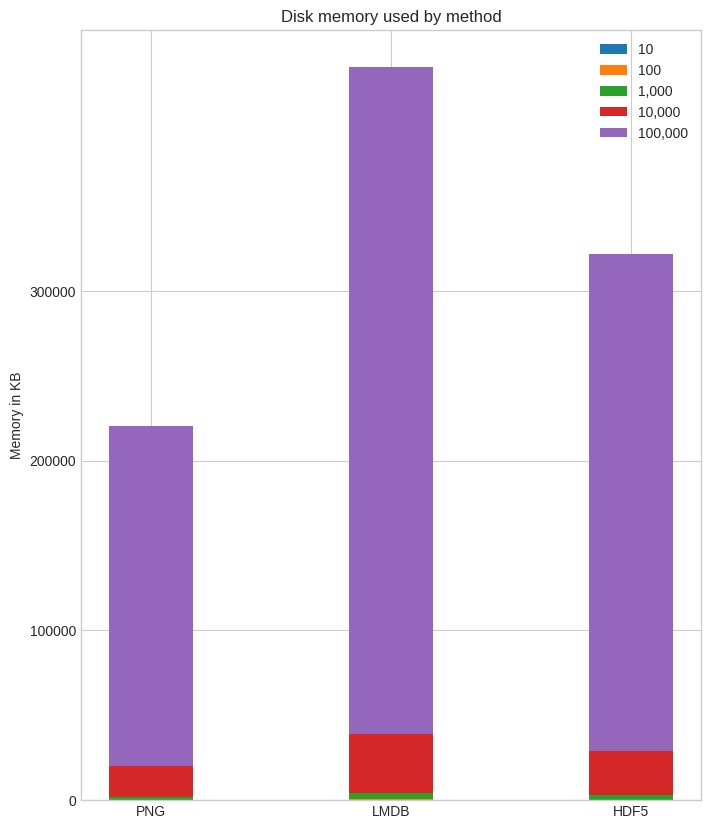

In [27]:
# Memory used in KB
disk_mem = [24, 204, 2004, 20032, 200296]
lmdb_mem = [60, 420, 4000, 39000, 393000]
hdf5_mem = [36, 304, 2900, 29000, 293000]

X = [disk_mem, lmdb_mem, hdf5_mem]

ind = np.arange(3)
width = 0.35

plt.subplots(figsize=(8, 10))
plots = [plt.bar(ind, [row[0] for row in X], width)]
for i in range(1, len(cutoffs)):
    plots.append(
        plt.bar(
            ind, [row[i] for row in X], width, bottom=[row[i - 1] for row in X]
        )
    )

plt.ylabel("Memory in KB")
plt.title("Disk memory used by method")
plt.xticks(ind, ("PNG", "LMDB", "HDF5"))
plt.yticks(np.arange(0, 400000, 100000))

plt.legend(
    [plot[0] for plot in plots], ("10", "100", "1,000", "10,000", "100,000")
)
plt.show()

Penggunaan memori penyimpanan dari ketika metode di atas menunjukan bahwa disk/PNG menggunakan memori paling sedikit baik dalam jumlah data kecil maupun besar. LMDB menggunakan memori paling banyak dibandingkan kedua metode lainnya.

## Kesimpulan
Dengan Pertimbangan Penggunaan memori/penyimpanan serta waktu proses menyimpan dan membaca data, HDF5 merupakan metode yang paling optimal untuk penggunaan data dalam jumlah banyak. Hal ini dibuktikan dengan waktu yang lebih sedikit digunakan seiring dengan jumlah data yang semakin besar namun dengan penggunaan memori yang relatif sedang.